# Model prediction and visualization for Contrails image segmentation

In [13]:
import pandas as pd
import numpy as np 
import os
from keras.models import load_model
import multiprocessing
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image
import pickle
import altair as alt
from PIL import Image 

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from keras.metrics import MeanIoU

from keras import losses
from keras import backend as K
# To use all available CPUs
n_cpus = multiprocessing.cpu_count()
print('CPUs available: ', n_cpus)
pandarallel.initialize(progress_bar=True, nb_workers=n_cpus)

CPUs available:  4
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# Basline variables
BATCH_SIZE = 32
total_classes = 2
IMAGE_CHANNELS = 3
# Hyper Parameters
NUM_EPOCHS = 50

# Test using filestore
# BASE_DIR = "../../../filestore_mount/contrails-data/"

# Using local disk
BASE_DIR = "../../kaggle-files/kaggle-contrails/contrails-kaggle-files/"

TRAIN_DIR = BASE_DIR + "train/"
VALIDATION_DIR = BASE_DIR + "validation/"
TEST_DIR = BASE_DIR + "test/"
validation_ids = os.listdir(VALIDATION_DIR)
test_ids = os.listdir(TEST_DIR)
MODELS_PATH = "../models/"
TRAIN_HISTORY_PATH = MODELS_PATH + "train_history/"


In [3]:
# Helper Functions

# Variables used to normalize and build Ash images 

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

class DataGenerator(keras.utils.Sequence):
    """ 
    This is a Keras Data generator used to load the images in batches for training.
    The Kaggle flag is used to build the ash images at runtime, instead of loading pre-built images from disk
    The time_series flag is used to pass the 8 time-series images from the ash image instead of only getting the 5th time-series image [...,4]
    The test flag is used to build the test dataset when submitting to Kaggle since it does not return a label, it just creates the ash image at runtime
    """
    
    def __init__(self, list_IDs, image_channels=3, batch_size=32, multiple_bands=False, shuffle=True, test=False, kaggle=False, time_series=False, only_contrails=False):
        'Initialization'
        self.indexes = np.arange(len(list_IDs))
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle 
        self.image_channels = image_channels
        self.test = test
        self.on_epoch_end()
        self.kaggle = kaggle
        self.time_series = time_series
        self.multiple_bands = multiple_bands
        self.only_contrails = only_contrails

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
            
        if self.test:
            """ Return only X """
            X = []
            for record_id in list_IDs_temp:
                if self.multiple_bands:
                    X.append(self.get_multiple_bands_image(record_id))
                elif self.only_contrails:
                    X.append(self.get_ash_image(record_id[:1])[...,record_id[2]])
                else:
                    X.append(self.get_ash_image(record_id)[...,4])
            return np.asarray(X)
        else:
            """ Return  X and y """
            X = []
            y = []

            for record_id in list_IDs_temp:
                if self.multiple_bands:
                    X.append(self.get_multiple_bands_image(record_id))
                elif self.only_contrails:
                    X.append(self.get_ash_image(record_id[:1])[...,record_id[2]])
                else:
                    X.append(self.get_ash_image(record_id)[...,4])
                y.append(np.load(record_id[0] + str(record_id[1]) + '/human_pixel_masks.npy'))
            return np.asarray(X), keras.utils.to_categorical(np.asarray(y), num_classes=2)
    
    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    def normalize_std(self, spec):
        return (spec- np.mean(spec))/np.std(spec)

    def get_multiple_bands_image(self, record_id):
        # Gets image_id string with the filder prexix included in the name
        # Returns numpy array with image and local path
        if self.kaggle:
            band_11 = np.load(record_id[0] + str(record_id[1]) + '/band_11.npy')
            band_13 = np.load(record_id[0] + str(record_id[1]) + '/band_13.npy')
            band_14 = np.load(record_id[0] + str(record_id[1]) + '/band_14.npy')
            band_15 = np.load(record_id[0] + str(record_id[1]) + '/band_15.npy')
            r = self.normalize_range(band_15 - band_14, _TDIFF_BOUNDS)
            g = self.normalize_range(band_14 - band_11, _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(band_14, _T11_BOUNDS)

            

            if self.time_series:
                multiple_bands_image = np.np.clip(np.stack([r,g,b,self.normalize_std(band_11), self.normalize_std(band_13), 
                                                          self.normalize_std(band_14), self.normalize_std(band_15)], axis=2), 0, 1)[...,2:5].reshape(256,256,3*self.image_channels)
            else:
                multiple_bands_image = np.clip(np.stack([r,g,b,self.normalize_std(band_11), self.normalize_std(band_13), 
                                                          self.normalize_std(band_14), self.normalize_std(band_15)], axis=2), 0, 1)[...,4]
        else:
            if self.time_series:
                multiple_bands_image = np.load(record_id[0] + str(record_id[1]) + '/multiple_bands_image.npy')[...,2:5].reshape(256,256,self.image_channels)
            else:
                multiple_bands_image = np.load(record_id[0] + str(record_id[1]) + '/multiple_bands_image.npy')[...,4]
        return multiple_bands_image
    
    
    def get_ash_image(self, record_id):
        # Gets image_id string with the filder prexix included in the name
        # Returns numpy array with image and local path
        if self.kaggle:
            band_11 = np.load(record_id[0] + str(record_id[1]) + '/band_11.npy')
            band_14 = np.load(record_id[0] + str(record_id[1]) + '/band_14.npy')
            band_15 = np.load(record_id[0] + str(record_id[1]) + '/band_15.npy')

            r = self.normalize_range(band_15 - band_14, _TDIFF_BOUNDS)
            g = self.normalize_range(band_14 - band_11, _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(band_14, _T11_BOUNDS)
            if self.time_series:
                ash_image = np.clip(np.stack([r, g, b], axis=2), 0, 1)[...,2:5].reshape(256,256,self.image_channels)
            else:
                ash_image = np.clip(np.stack([r, g, b], axis=2), 0, 1)[...,4]
        else:
            if self.time_series:
                ash_image = np.load(record_id[0] + str(record_id[1]) + '/ash_image.npy')[...,2:5].reshape(256,256,self.image_channels)
            else:
                ash_image = np.load(record_id[0] + str(record_id[1]) + '/ash_image.npy')
        return ash_image
 
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

def jaccard_coef(y_true, y_pred):
    """
    Defines custom jaccard coefficient metric
    """
    
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value



def real_dice_coeff(y_true, y_pred):
    smooth = 0.0001
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice_score = (2.0 * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice_score


def calc_dice_loss(y_true, y_pred):
    loss = 1 - real_dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + calc_dice_loss(y_true, y_pred)
    return loss


def visualize_train_curves(train_history, title):
    """ 
    This function plots the main metrics used during model training and prints the last epoch's metrics values
    """
    train_loss, train_iou_score, train_mean_iou, train_accuracy, train_jaccard_coef, train_dice_coeficient, val_loss, val_iou_score, val_mean_iou, val_accuracy, val_jaccard_coef, val_dice_coeficient  = train_history.values() 

     # Visualize loss Results
    epochs = range(1, len(train_history['loss']) + 1)
    
    fig, ax = plt.subplots(2, 2, figsize=(18, 10))
    fig.tight_layout(pad=5.0)


    l1, = ax[0, 0].plot(epochs, train_loss, 'g')
    l2, = ax[0, 0].plot(epochs, val_loss, 'r')
    ax[0, 0].set_title("Loss")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")


    ax[0, 1].plot(epochs, train_mean_iou, 'g')
    ax[0, 1].plot(epochs, val_mean_iou, 'r')
    ax[0, 1].set_title("Mean IoU")
    ax[0, 1].set_ylabel("Mean IoU")
    ax[0, 1].set_xlabel("Epochs")


    ax[1,0].plot(epochs, train_jaccard_coef, 'g')
    ax[1,0].plot(epochs, val_jaccard_coef, 'r')
    ax[1,0].set_title("Jaccard Coef")
    ax[1,0].set_xlabel("Epochs")
    ax[1,0].set_ylabel("Jaccard Coef")


    ax[1,1].plot(epochs, train_dice_coeficient, 'g', label="Train Dice Coeficient")
    ax[1,1].plot(epochs, val_dice_coeficient, 'r', label="Val Dice Coeficient")
    ax[1,1].set_title("Dice Coeficient")
    ax[1,1].set_ylabel("Dice Coeficient")
    ax[1,1].set_xlabel("Epochs")
    fig.suptitle(title, fontsize=16)
    

    fig.legend((l1,l2),('Training', 'Validation'), loc='upper left')
    plt.show()
    
    print("Model's last epoch's metrics:")
    for item in train_history:
        print(f'{item} = {train_history[item][-1]:.4f}')
    


In [4]:
# Data loading

# train_id_list = [(TRAIN_DIR, record_id) for record_id in os.listdir(TRAIN_DIR)]
validation_id_list = [(VALIDATION_DIR, record_id) for record_id in os.listdir(VALIDATION_DIR)]

# """ full_id_list is only used to train in Kaggle using both Train and Validation records (images) """
# full_id_list = train_id_list + validation_id_list

# """ test_id_list is also only used in Kaggle to create the csv file needed for the submission """
# test_id_list = [(TEST_DIR, record_id) for record_id in os.listdir(TEST_DIR)]


validation_generator = DataGenerator(validation_id_list, image_channels=3, batch_size=BATCH_SIZE, shuffle=True, test=False, kaggle=False)

# test_generator = DataGenerator(test_id_list, image_channels=3, batch_size=1, shuffle=False, test=True, kaggle=True)
# training_generator = DataGenerator(train_id_list, image_channels=3, batch_size=BATCH_SIZE, kaggle=False)



# Models metrics

weights = [0.5,0.5] # hyper parameter

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
TOTAL_LOSS_FACTOR = 5
total_loss = dice_loss + (TOTAL_LOSS_FACTOR * focal_loss)

metrics = [real_dice_coeff, tf.keras.metrics.MeanIoU(num_classes=2, sparse_y_true= False, sparse_y_pred=False, name="Mean IOU"), "accuracy", jaccard_coef, sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")]


2023-07-28 19:20:42.293536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-28 19:20:42.370522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-28 19:20:42.372335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
# Helper functions for visualization and metrics

def get_contrail_ratio(row):
    label = np.load(row[0] + str(row[1]) + '/human_pixel_masks.npy')
    return np.count_nonzero(label)/(256*256)

def get_prediction(ash_image, model):
    y_pred = model.predict(ash_image.reshape(1,256, 256, 3), verbose = 0)
    prediction = np.argmax(y_pred[0], axis=2)
    return prediction

def get_label(path, record_id):
    label = np.load(path + str(record_id) + '/human_pixel_masks.npy')
    return label

def get_ash_image(path, record_id):
    ash_image = np.load(path + str(record_id) + '/ash_image.npy')[...,4]
    return ash_image

def get_color_prediction(path, record_id, model_name="unet"):
    color_prediction = np.asarray(Image.open(path + str(record_id) + '/' + model_name + '_color_prediction.png'))
    return color_prediction

def get_single_image_iou(path, record_id, model):
    IOU_keras.reset_state()
    label = get_label(path, record_id)
    ash_image = get_ash_image(path, record_id)
    prediction = get_prediction(ash_image, model)
    IOU_keras.update_state(label, prediction)
    mean_IOU = IOU_keras.result().numpy()
    return mean_IOU 


def get_single_image_accuracy(path, record_id, model):
    label = get_label(path, record_id)
    ash_image = get_ash_image(path, record_id)
    prediction = get_prediction(ash_image, model)
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(label, prediction)
    return accuracy.result().numpy()

def get_single_record_metrics(dataframe, model):
    single_prediction_IOU = []
    single_prediction_accuracy = []

    for index, row in validation_df.iterrows():
        IOU_keras = MeanIoU(num_classes=2) 
        label = get_label(row['path'], row['record_id'])
        ash_image = get_ash_image(row['path'], row['record_id'])
        prediction = get_prediction(ash_image, model)

        IOU_keras.update_state(label, prediction)
        mean_IOU = IOU_keras.result().numpy()
        accuracy = tf.keras.metrics.Accuracy()
        accuracy.update_state(label, prediction)

        single_prediction_IOU.append(IOU_keras.result().numpy())
        single_prediction_accuracy.append(accuracy.result().numpy())
        IOU_keras.reset_state()
    return single_prediction_IOU, single_prediction_accuracy


def save_color_prediction(dataframe, model, model_name):
    intersection_ratio = []
    false_negative_ratio = []
    false_possitive_ratio = []
    images_path = []
    for index, row in validation_df.iterrows():
        IOU_keras = MeanIoU(num_classes=2) 
        label = get_label(row['path'], row['record_id'])
        ash_image = get_ash_image(row['path'], row['record_id'])
        prediction = get_prediction(ash_image, model).reshape(256,256,1)
        intersection = label&prediction
        false_negative = label - intersection
        false_possitive = prediction - intersection 
        color_prediction = np.stack([false_negative*.7, intersection*.7, false_possitive*.7], axis=2).reshape(256,256,3)

        image_path = row['path'] + row['record_id'] + '/' + model_name + '_color_prediction.png'
        matplotlib.image.imsave(image_path, color_prediction)  
        if np.count_nonzero(label) == 0:
            intersection_ratio.append(0)
            false_negative_ratio.append(0)
            false_possitive_ratio.append(0)

        else:
            intersection_ratio.append(np.count_nonzero(intersection)/np.count_nonzero(label))
            false_negative_ratio.append(np.count_nonzero(false_negative)/np.count_nonzero(label))
            false_possitive_ratio.append(np.count_nonzero(false_possitive)/np.count_nonzero(label))
        images_path.append(image_path)
    return intersection_ratio, false_negative_ratio, false_possitive_ratio, image_path

def display_image_and_label(path, record_id, contrail_ratio, mean_IOU, model, model_name, title):
    label = get_label(path, record_id)
    ash_image = get_ash_image(path, record_id)
    prediction = get_prediction(ash_image, model)
    color_prediction = get_color_prediction(path, record_id, model_name=model_name)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    fig.tight_layout(pad=5.0)
    ax[0].set_title("Label (ground truth)")
    ax[0].imshow(label)
    ax[0].axis('off')

    ax[1].set_title("False color image")
    ax[1].imshow(ash_image)
    ax[1].axis('off')

    fig.suptitle(f'{title}\nRecord ID: {str(record_id)} \nContrail Ratio = {contrail_ratio:.5f}')
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    fig.tight_layout()

    red_patch = mpatches.Patch(color='red', label='False Negatives')
    blue_patch = mpatches.Patch(color='blue', label='False Postitives')
    green_patch = mpatches.Patch(color='green', label='Correct prediction')



    ax[0].imshow(prediction)
    ax[0].set_title("Prediction")
    ax[0].axis('off')

    ax[1].imshow(color_prediction)
    ax[1].set_title("Colored prediction")
    ax[1].axis('off')
    ax[1].legend(handles=[red_patch, blue_patch, green_patch],loc='upper left', bbox_to_anchor=(1, 1))

    fig.suptitle(f'{model_name.capitalize()} Prediction Mean IOU = {mean_IOU:.5f}')
    
def get_single_record_metrics(dataframe, model):
    """ 
    Returns two lists, one with individual Mean IOU of each individual prediction 
    and the second list includes the individual accuracy
    """
    single_prediction_IOU = []
    single_prediction_accuracy = []

    for index, row in validation_df.iterrows():
        IOU_keras = MeanIoU(num_classes=2) 
        label = get_label(row['path'], row['record_id'])
        ash_image = get_ash_image(row['path'], row['record_id'])
        prediction = get_prediction(ash_image, model)

        IOU_keras.update_state(label, prediction)
        mean_IOU = IOU_keras.result().numpy()
        accuracy = tf.keras.metrics.Accuracy()
        accuracy.update_state(label, prediction)

        single_prediction_IOU.append(IOU_keras.result().numpy())
        single_prediction_accuracy.append(accuracy.result().numpy())
        IOU_keras.reset_state()
    return single_prediction_IOU, single_prediction_accuracy



In [26]:
# Unet metrics
model_name = 'unet_contrails_model.keras'
model = load_model('../../../fast-disk/w210-capstone/models/' + model_name, custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef, 'IOU score' : sm.metrics.IOUScore(threshold=0.9, name="IOU score"), 'Dice Coeficient' : sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")}, compile=False)
model.compile(metrics=metrics)
validation_df['Unet_mean_IOU'], validation_df['Unet_accuracy'] = get_single_record_metrics(validation_df, model)
validation_df['Unet_intersection_ratio'], validation_df['Unet_false_negative_ratio'], validation_df['Unet_false_positive_ratio'], validation_df['Unet_prediction_image'] = save_color_prediction(validation_df, model, "unet")


In [11]:
model_name = 'Trans_Unet_w_only_contrails_lr_decay_50_epochs.keras'
model = load_model('../../../fast-disk/w210-capstone/models/' + model_name, custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef, 'IOU score' : sm.metrics.IOUScore(threshold=0.9, name="IOU score"), 'Dice Coeficient' : sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")}, compile=False)
model.compile(metrics=metrics)
validation_df['TransUnet_mean_IOU'], validation_df['TransUnet_accuracy'] = get_single_record_metrics(validation_df, model)
validation_df['TransUnet_intersection_ratio'], validation_df['TransUnet_false_negative_ratio'], validation_df['TransUnet_false_positive_ratio'], validation_df['TransUnet_prediction_image'] = save_color_prediction(validation_df, model, "transunet")


2023-07-28 19:29:18.452267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8900


### Metrics analysis 

In [8]:
# """ Executed only once to create dataframe and then read from file """

# Create dataframe and calculate the contrail ratio of each record
# Commented out so it is not processed again

# validation_df = pd.DataFrame(validation_id_list, columns =['path', 'record_id'])
# validation_df['contrail_ratio'] = validation_df.parallel_apply(get_contrail_ratio, axis=1)


# ### Capture model's individual metrics
# metrics = [real_dice_coeff, tf.keras.metrics.MeanIoU(num_classes=2, sparse_y_true= False, sparse_y_pred=False, name="Mean IOU"), "accuracy", jaccard_coef, sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")]

# # Unet metrics
# model_name = 'unet_contrails_model.keras'
# model = load_model('../../../fast-disk/w210-capstone/models/' + model_name, custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef, 'IOU score' : sm.metrics.IOUScore(threshold=0.9, name="IOU score"), 'Dice Coeficient' : sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")}, compile=False)
# model.compile(metrics=metrics)
# # validation_df['Unet_mean_IOU'], validation_df['Unet_accuracy'] = get_single_record_metrics(validation_df, model)
# validation_df['Unet_intersection_ratio'], validation_df['Unet_false_negative_ratio'], validation_df['Unet_false_positive_ratio'], validation_df['Unet_prediction_image'] = save_color_prediction(validation_df, model, "unet")


# # # # # TransUnet metrics
# model_name = 'Trans_Unet_w_lr_decay_50_epochs.keras'
# model = load_model('../../../fast-disk/w210-capstone/models/' + model_name, custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef, 'IOU score' : sm.metrics.IOUScore(threshold=0.9, name="IOU score"), 'Dice Coeficient' : sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")}, compile=False)
# model.compile(metrics=metrics)
# validation_df['TransUnet_mean_IOU'], validation_df['TransUnet_accuracy'] = get_single_record_metrics(validation_df, model)
# validation_df['TransUnet_intersection_ratio'], validation_df['TransUnet_false_negative_ratio'], validation_df['TransUnet_false_positive_ratio'], validation_df['TransUnet_prediction_image'] = save_color_prediction(validation_df, model, "transunet")


# # Save Dataframe to disk
# validation_df.to_json('../metadata/validation_df.json')


In [9]:
# Start executing from this line

data_types = {'record_id': str} 
validation_df = pd.read_json('../metadata/validation_df.json', dtype=data_types)

# Image prediction visualization


### Training curve Unet Model 

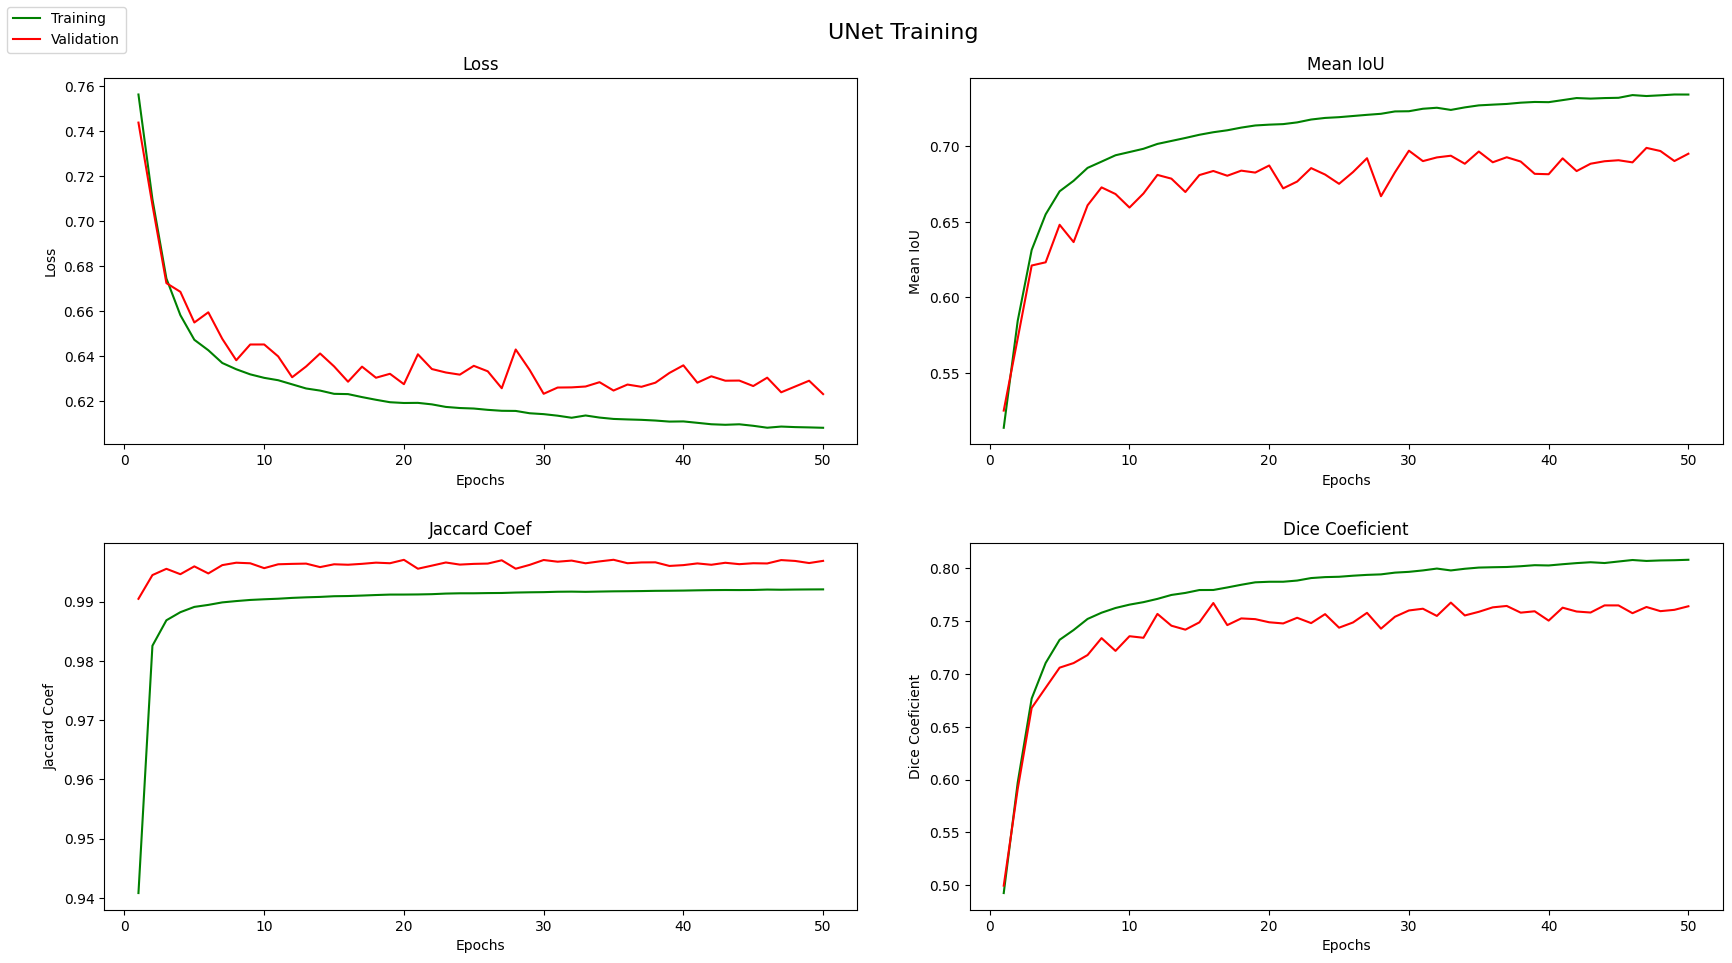

Model's last epoch's metrics:
loss = 0.6082
IOU score = 0.7224
Mean IOU = 0.7342
accuracy = 0.9962
jaccard_coef = 0.9921
Dice Coeficient = 0.8082
val_loss = 0.6232
val_IOU score = 0.6814
val_Mean IOU = 0.6951
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7642


In [54]:
model_name = "Baseline_Unet_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "UNet Training")

### Training curve TransUnet Model 

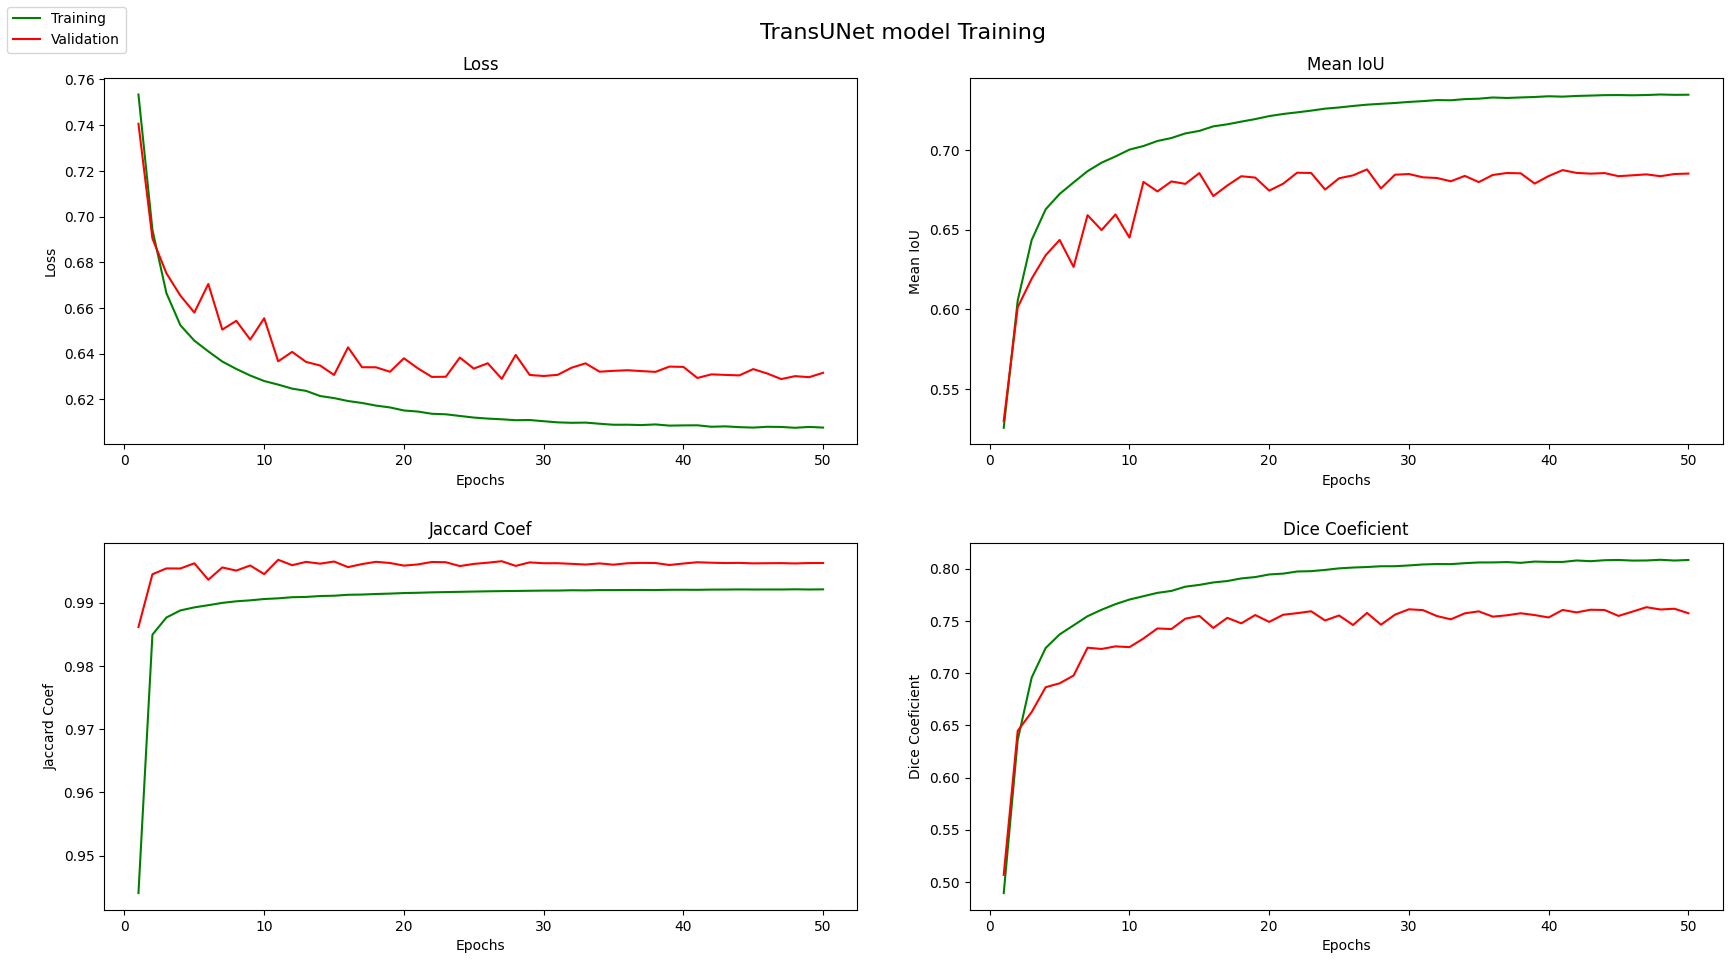

Model's last epoch's metrics:
loss = 0.6076
IOU score = 0.7227
Mean IOU = 0.7348
accuracy = 0.9962
jaccard_coef = 0.9921
Dice Coeficient = 0.8084
val_loss = 0.6316
val_IOU score = 0.6750
val_Mean IOU = 0.6853
val_accuracy = 0.9982
val_jaccard_coef = 0.9963
val_Dice Coeficient = 0.7574


In [55]:
model_name = "Trans_Unet_w_lr_decay_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "TransUNet model Training")


# Sample Image Visualization with Unet Model

In [131]:
# Unet model
model_name = 'unet_contrails_model.keras'
model = load_model('../../../fast-disk/w210-capstone/models/' + model_name, custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef, 'IOU score' : sm.metrics.IOUScore(threshold=0.9, name="IOU score"), 'Dice Coeficient' : sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")}, compile=False)
model.compile(metrics=metrics)

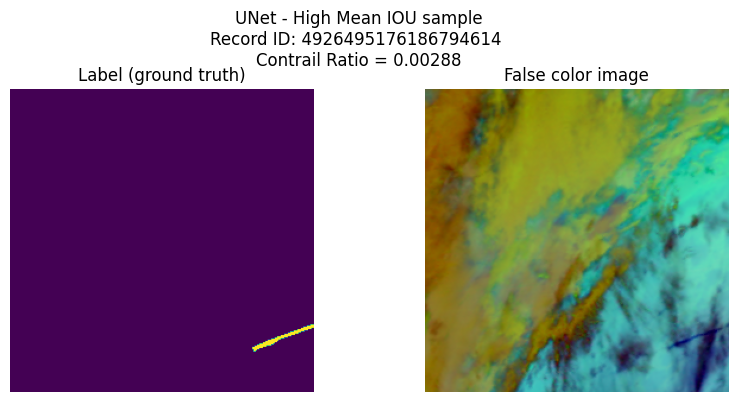

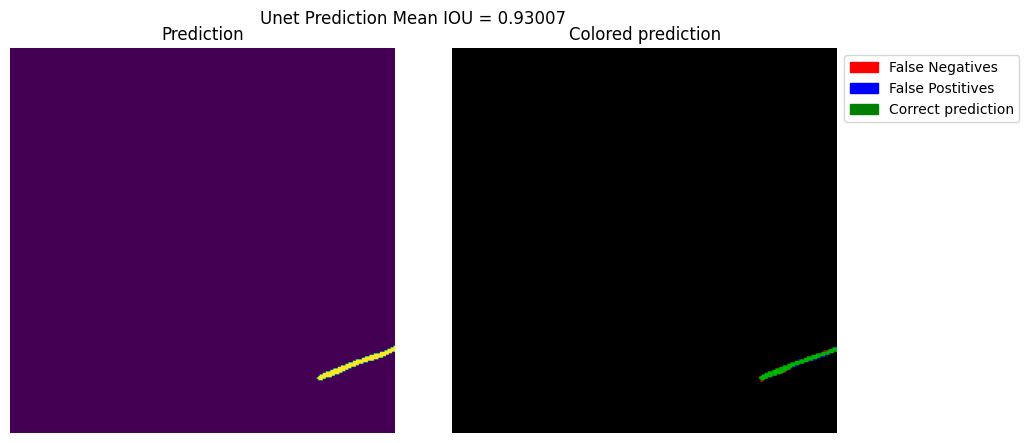

In [132]:
# Unet model 
title = "UNet - High Mean IOU sample"
row = validation_df[validation_df.record_id =='4926495176186794614'].iloc[0]
display_image_and_label(row.path, row.record_id, row.contrail_ratio, row.Unet_mean_IOU, model, model_name = "unet", title=title)

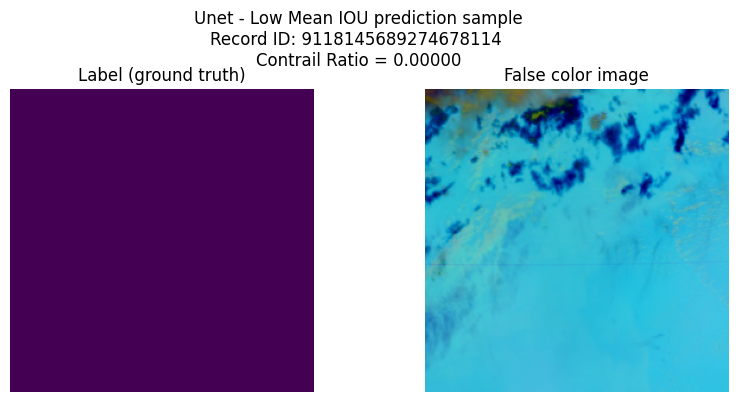

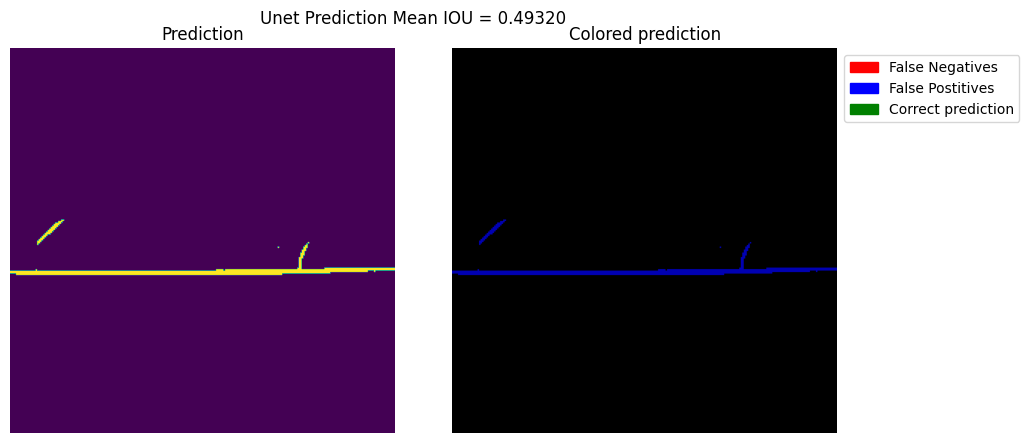

In [133]:
# Low prediction sample
title = 'Unet - Low Mean IOU prediction sample'
row = validation_df[validation_df.record_id =='9118145689274678114'].iloc[0]
display_image_and_label(row.path, row.record_id, row.contrail_ratio, row.Unet_mean_IOU, model, model_name = "unet", title=title)



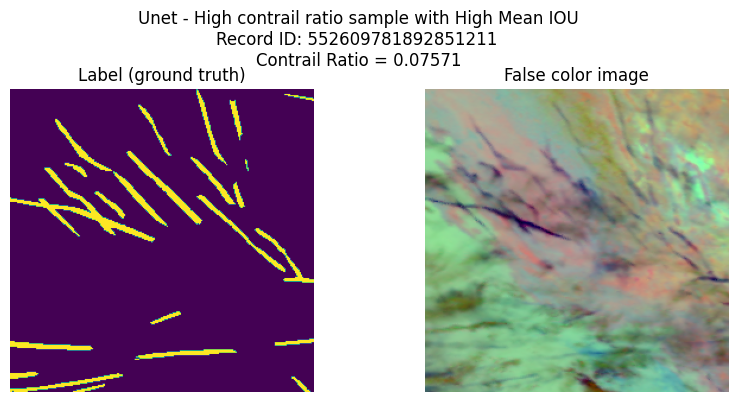

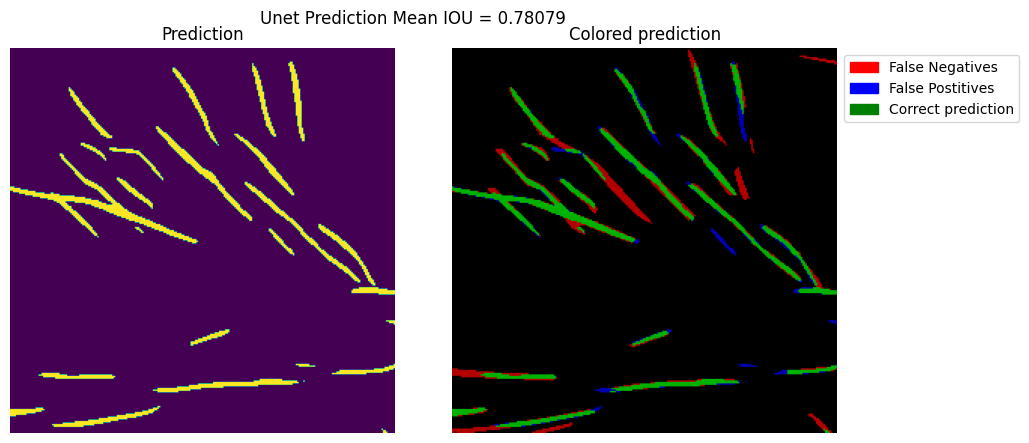

In [134]:
# High contrail ratio sample with High Mean IOU
title = 'Unet - High contrail ratio sample with High Mean IOU'
row = validation_df[validation_df.record_id =='552609781892851211'].iloc[0]
display_image_and_label(row.path, row.record_id, row.contrail_ratio, row.Unet_mean_IOU, model, model_name = "unet",title=title)

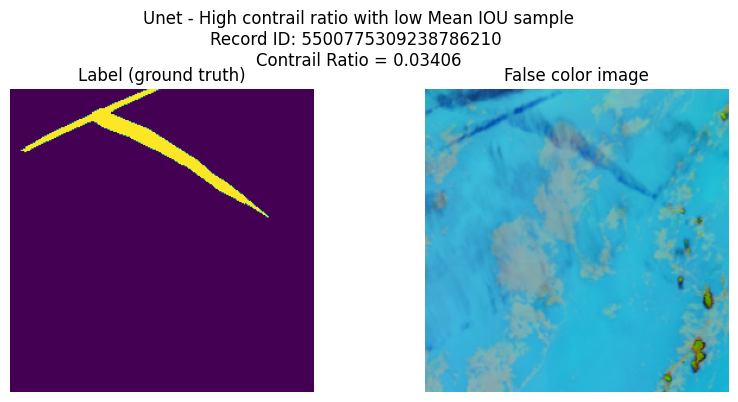

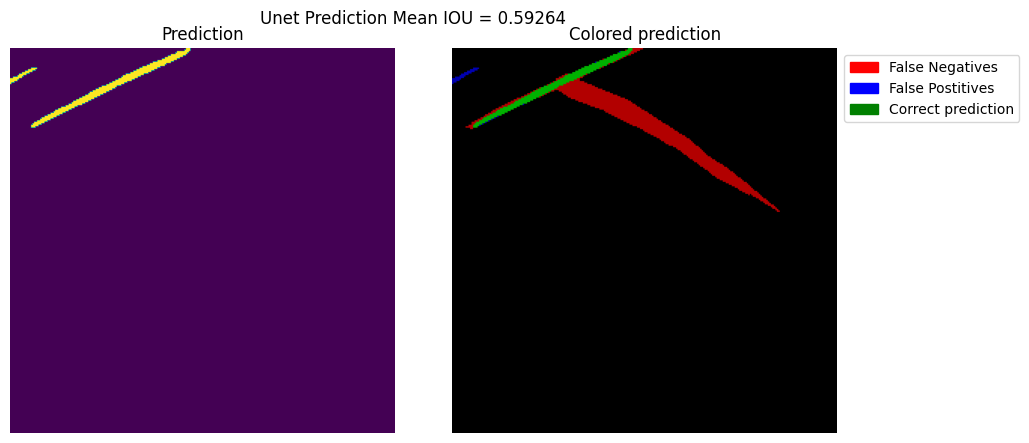

In [136]:
# High contrail ratio with low Mean IOU sample
title = 'Unet - High contrail ratio with low Mean IOU sample'
row = validation_df[validation_df.record_id =='5500775309238786210'].iloc[0]
display_image_and_label(row.path, row.record_id, row.contrail_ratio, row.Unet_mean_IOU, model, model_name = "unet", title=title)



# Sample Image Visualization with TransUnet Model

In [137]:
model_name = 'Trans_Unet_w_lr_decay_50_epochs.keras'
model = load_model('../../../fast-disk/w210-capstone/models/' + model_name, custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef, 'IOU score' : sm.metrics.IOUScore(threshold=0.9, name="IOU score"), 'Dice Coeficient' : sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")}, compile=False)
model.compile(metrics=metrics)

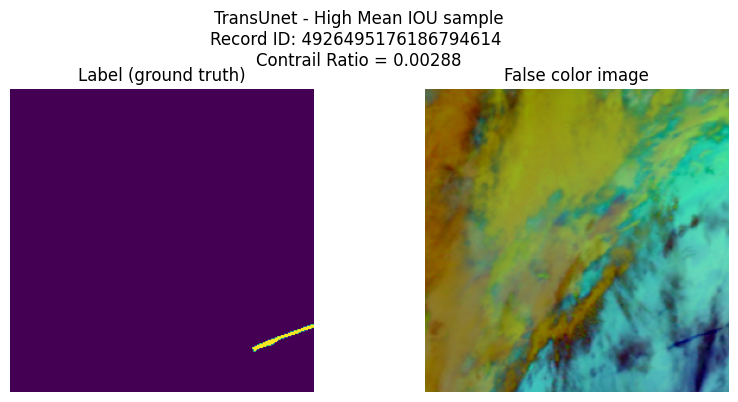

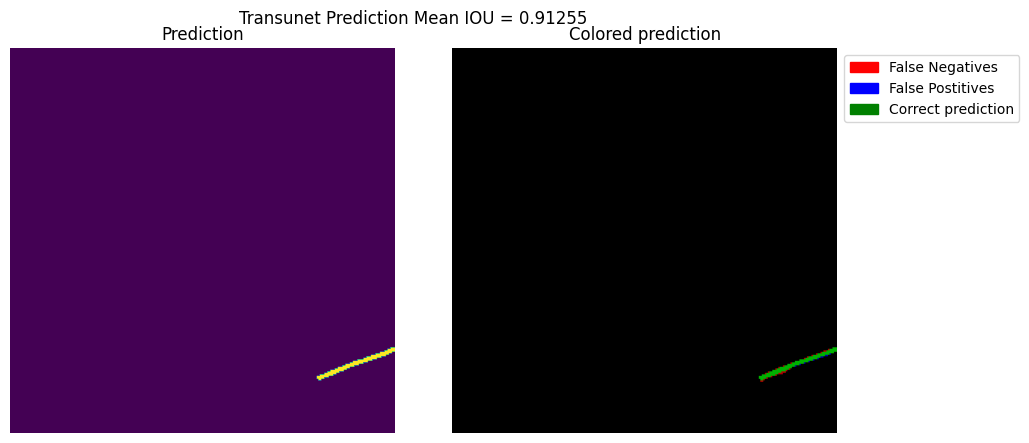

In [19]:
# TransUnet model 
title = "TransUnet - High Mean IOU sample"
row = validation_df[validation_df.record_id =='4926495176186794614'].iloc[0]
display_image_and_label(row.path, row.record_id, row.contrail_ratio, row.TransUnet_mean_IOU, model, model_name = "transunet", title=title)

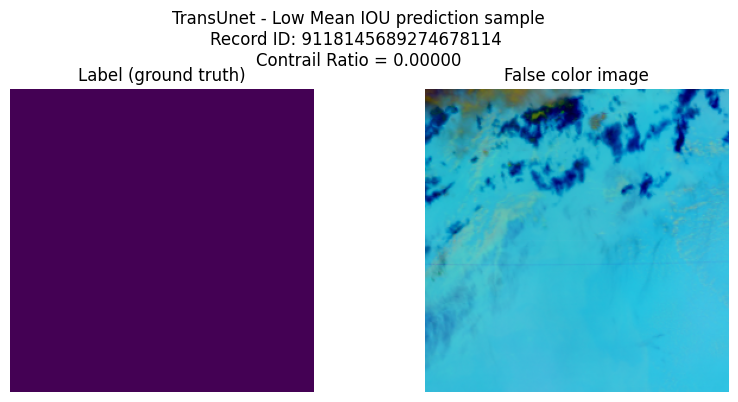

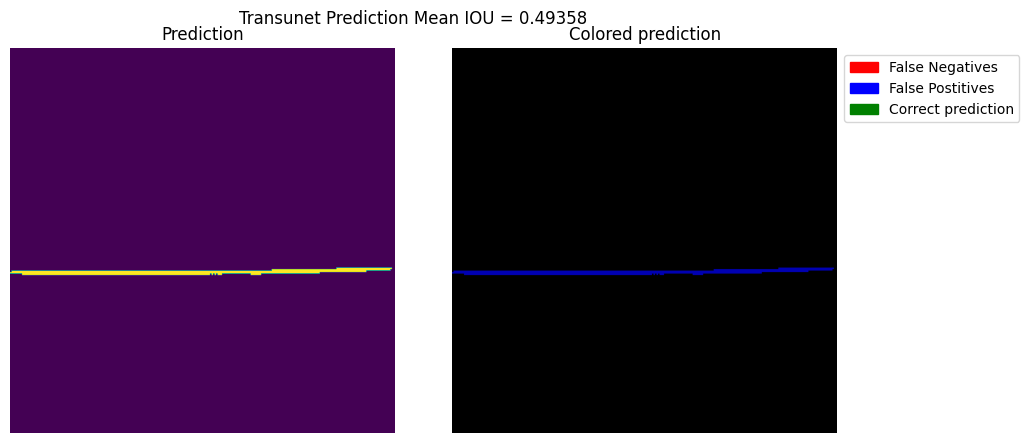

In [22]:
# Low prediction sample
title = "TransUnet - Low Mean IOU prediction sample"
row = validation_df[validation_df.record_id =='9118145689274678114'].iloc[0]
display_image_and_label(row.path, row.record_id, row.contrail_ratio, row.TransUnet_mean_IOU, model, model_name = "transunet", title=title)


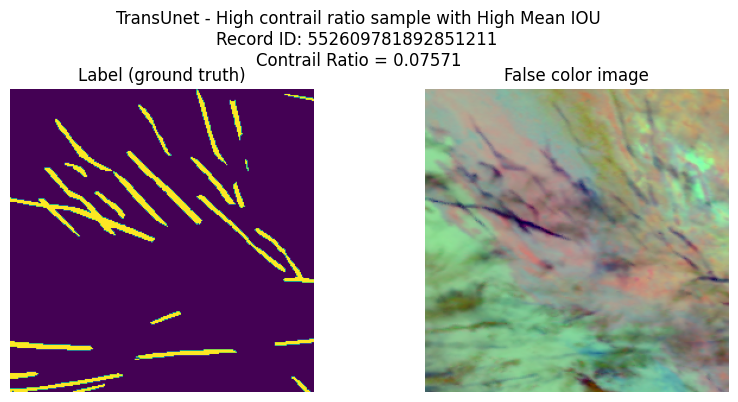

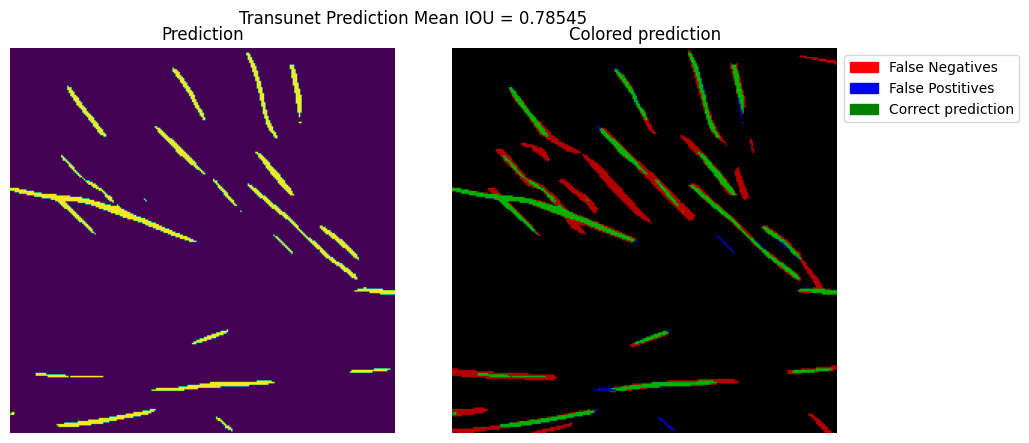

In [23]:
# High contrail ratio sample with High Mean IOU
title = 'TransUnet - High contrail ratio sample with High Mean IOU'
row = validation_df[validation_df.record_id =='552609781892851211'].iloc[0]
display_image_and_label(row.path, row.record_id, row.contrail_ratio, row.TransUnet_mean_IOU, model, model_name = "transunet", title=title)

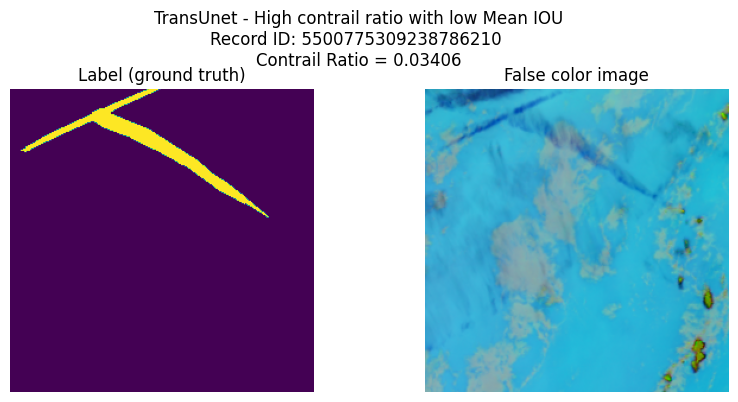

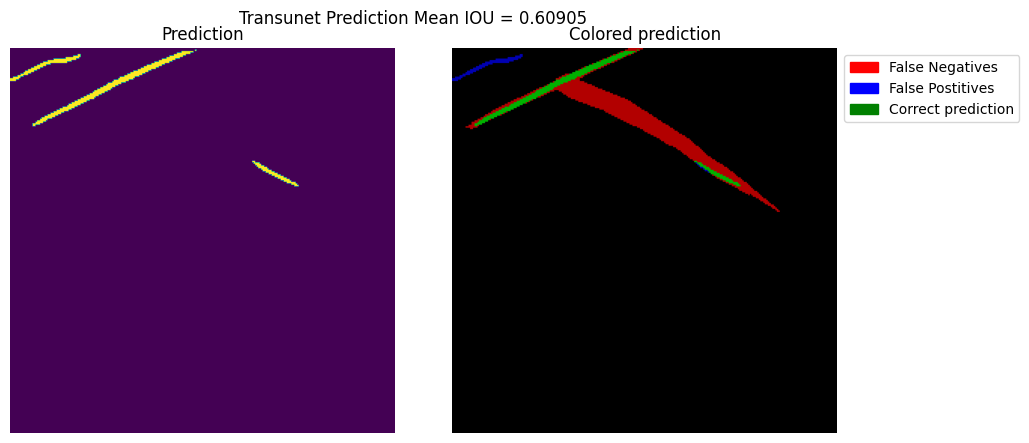

In [25]:
# High contrail ratio with low Mean IOU sample
title = 'TransUnet - High contrail ratio with low Mean IOU'
row = validation_df[validation_df.record_id =='5500775309238786210'].iloc[0]
display_image_and_label(row.path, row.record_id, row.contrail_ratio, row.TransUnet_mean_IOU, model, model_name = "transunet", title=title)


In [142]:
validation_df.describe()

contrail_ratio  Unet_mean_IOU  Unet_accuracy  Unet_intersection_ratio  \
count     1856.000000    1856.000000    1856.000000              1856.000000   
mean         0.001812       0.788821       0.998348                 0.155139   
std          0.005337       0.219431       0.003810                 0.296634   
min          0.000000       0.492615       0.962601                 0.000000   
25%          0.000000       0.499947       0.998581                 0.000000   
50%          0.000000       0.838150       0.999908                 0.000000   
75%          0.000916       1.000000       1.000000                 0.000000   
max          0.075714       1.000000       1.000000                 1.000000   

       Unet_false_negative_ratio  Unet_false_positive_ratio  \
count                1856.000000                1856.000000   
mean                    0.142275                   0.155715   
std                     0.280978                   0.605946   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.135720                   0.019644   
max                     1.000000                  17.157895   

       TransUnet_mean_IOU  TransUnet_accuracy  TransUnet_intersection_ratio  \
count         1856.000000         1856.000000                   1856.000000   
mean             0.790990            0.998233                      0.141380   
std              0.221292            0.004064                      0.284766   
min              0.493423            0.960968                      0.000000   
25%              0.499924            0.998379                      0.000000   
50%              0.852816            0.999954                      0.000000   
75%              1.000000            1.000000                      0.000000   
max              1.000000            1.000000                      1.000000   

       TransUnet_false_negative_ratio  TransUnet_false_positive_ratio  
count                     1856.000000                     1856.000000  
mean                         0.156034                        0.158353  
std                          0.302312                        0.589960  
min                          0.000000                        0.000000  
25%                          0.000000                        0.000000  
50%                          0.000000                        0.000000  
75%                          0.160268                        0.000000  
max                          1.000000                       11.000000

In [112]:
validation_df[validation_df.Unet_mean_IOU <1.0].sort_values('contrail_ratio', ascending=False).head(10)

path            record_id  \
1082  ../../kaggle-files/kaggle-contrails/contrails-...   552609781892851211   
700   ../../kaggle-files/kaggle-contrails/contrails-...  3268948859446517114   
1567  ../../kaggle-files/kaggle-contrails/contrails-...  2399738000417381513   
1413  ../../kaggle-files/kaggle-contrails/contrails-...  1205045288117020016   
860   ../../kaggle-files/kaggle-contrails/contrails-...  5663079497093130113   
642   ../../kaggle-files/kaggle-contrails/contrails-...  4182340004986797719   
1013  ../../kaggle-files/kaggle-contrails/contrails-...  9000307066571621514   
854   ../../kaggle-files/kaggle-contrails/contrails-...  4617259572479165215   
275   ../../kaggle-files/kaggle-contrails/contrails-...  5500775309238786210   
302   ../../kaggle-files/kaggle-contrails/contrails-...  3517995218957041214   

      contrail_ratio  Unet_mean_IOU  Unet_accuracy  Unet_intersection_ratio  \
1082        0.075714       0.780792       0.965958                 0.667271   
700         0.061691       0.773725       0.967026                 0.744249   
1567        0.056274       0.713676       0.962601                 0.579989   
1413        0.045700       0.715086       0.970703                 0.546578   
860         0.042068       0.752221       0.977554                 0.595575   
642         0.037857       0.743773       0.976440                 0.652156   
1013        0.035019       0.799106       0.981339                 0.860131   
854         0.034515       0.765245       0.982483                 0.616269   
275         0.034058       0.592645       0.972488                 0.218638   
302         0.033875       0.838385       0.987198                 0.840991   

      Unet_false_negative_ratio  Unet_false_positive_ratio  \
1082                   0.332729                   0.116888   
700                    0.255751                   0.278753   
1567                   0.420011                   0.244577   
1413                   0.453422                   0.187646   
860                    0.404425                   0.129126   
642                    0.347844                   0.274486   
1013                   0.139869                   0.393028   
854                    0.383731                   0.123784   
275                    0.781362                   0.026434   
302                    0.159009                   0.218919   

                                  Unet_prediction_image  \
1082  ../../kaggle-files/kaggle-contrails/contrails-...   
700   ../../kaggle-files/kaggle-contrails/contrails-...   
1567  ../../kaggle-files/kaggle-contrails/contrails-...   
1413  ../../kaggle-files/kaggle-contrails/contrails-...   
860   ../../kaggle-files/kaggle-contrails/contrails-...   
642   ../../kaggle-files/kaggle-contrails/contrails-...   
1013  ../../kaggle-files/kaggle-contrails/contrails-...   
854   ../../kaggle-files/kaggle-contrails/contrails-...   
275   ../../kaggle-files/kaggle-contrails/contrails-...   
302   ../../kaggle-files/kaggle-contrails/contrails-...   

                                                  image  TransUnet_mean_IOU  \
1082  ../../kaggle-files/kaggle-contrails/contrails-...            0.785452   
700   ../../kaggle-files/kaggle-contrails/contrails-...            0.771361   
1567  ../../kaggle-files/kaggle-contrails/contrails-...            0.716497   
1413  ../../kaggle-files/kaggle-contrails/contrails-...            0.751426   
860   ../../kaggle-files/kaggle-contrails/contrails-...            0.704311   
642   ../../kaggle-files/kaggle-contrails/contrails-...            0.717259   
1013  ../../kaggle-files/kaggle-contrails/contrails-...            0.793403   
854   ../../kaggle-files/kaggle-contrails/contrails-...            0.756509   
275   ../../kaggle-files/kaggle-contrails/contrails-...            0.609051   
302   ../../kaggle-files/kaggle-contrails/contrails-...            0.808665   

      TransUnet_accuracy  TransUnet_intersection_ratio  \
1082            0.966705               

In [129]:

chart = alt.Chart(validation_df[(validation_df.contrail_ratio<1) & (validation_df.Unet_mean_IOU<1)]).mark_circle(size=80).encode(
    x=alt.X('contrail_ratio', title='Contrail Ratio', scale=alt.Scale(zero=True)),
    y=alt.Y('Unet_mean_IOU', title='MeanIOU with Unet Model'),
    tooltip=['record_id', 'Unet_mean_IOU', 'contrail_ratio', 'image'],
    ).properties(height=400, width="container")

chart_w_line = chart + chart.transform_regression('contrail_ratio', 'Unet_mean_IOU').mark_line(strokeWidth=4).transform_fold(["*Regression-line*"], as_=["Regression", "y"]).encode(alt.Color("Regression:N"))

chart_w_line.interactive()

alt.LayerChart(...)

In [ ]:
# Load model for prediction
model = load_model('../../../fast-disk/w210-capstone/models/Trans_Unet_w_lr_decay_50_epochs.keras',custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef, 'IOU score' : sm.metrics.IOUScore(threshold=0.9, name="IOU score"), 'Dice Coeficient' : sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")}, compile=False)

model.compile(metrics=metrics)

In [144]:
from huggingface_hub import push_to_hub_keras

push_to_hub_keras(model,
    "MIDSCapstoneTeam/ContrailSentinel",use_auth_token=access_token
)

INFO:tensorflow:Assets written to: /var/tmp/tmphf45jllr/MIDSCapstoneTeam/ContrailSentinel/assets


INFO:tensorflow:Assets written to: /var/tmp/tmphf45jllr/MIDSCapstoneTeam/ContrailSentinel/assets


Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

keras_metadata.pb:   0%|          | 0.00/466k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/283M [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/4.33M [00:00<?, ?B/s]

'https://huggingface.co/MIDSCapstoneTeam/ContrailSentinel/tree/main/'

2023-07-27 23:19:03.015955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8900


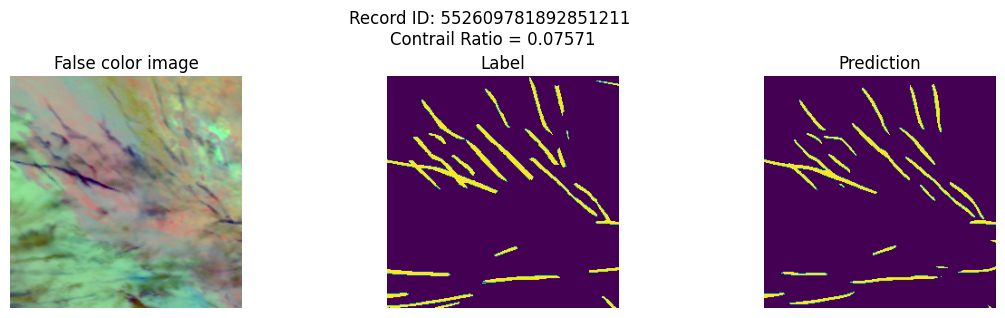

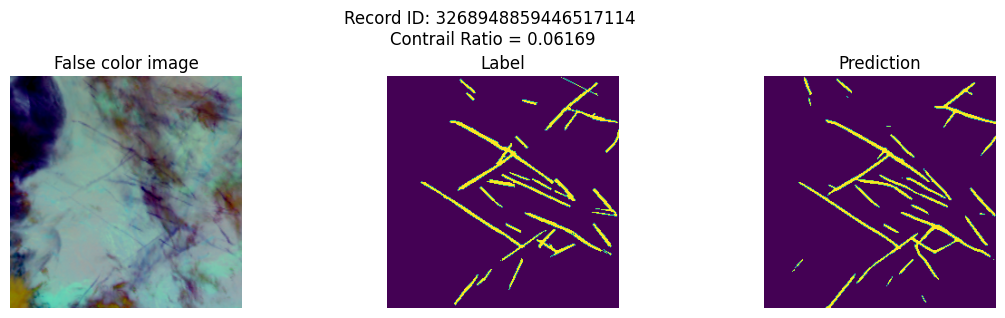

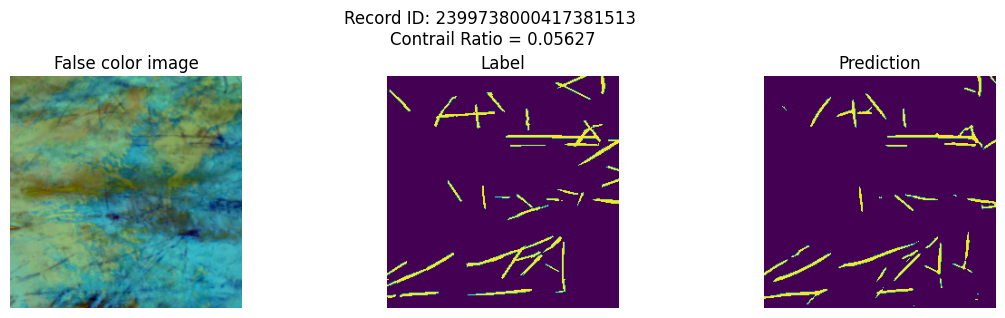

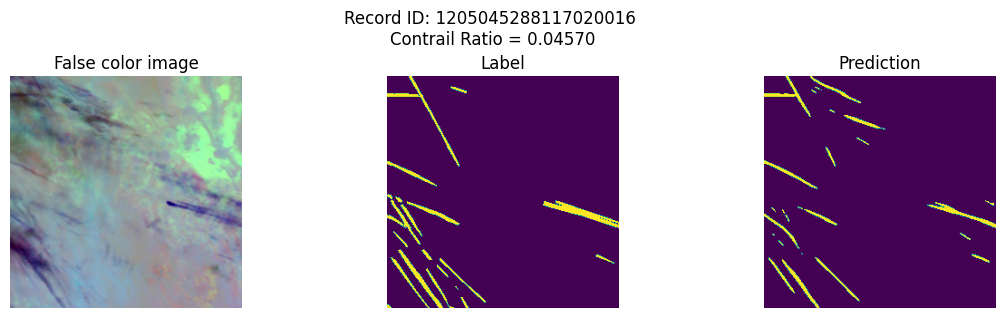

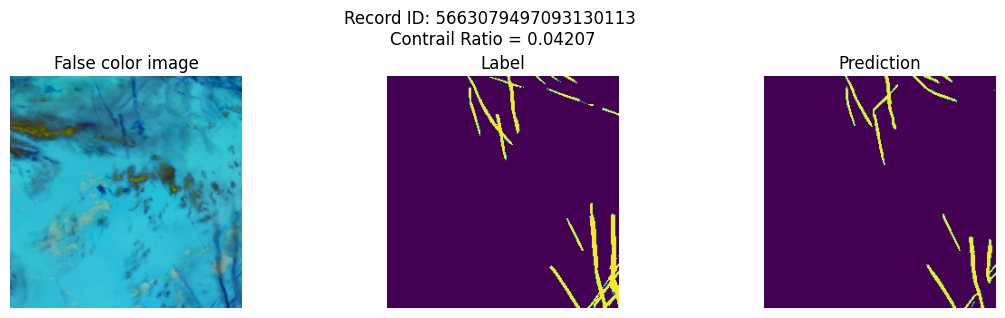

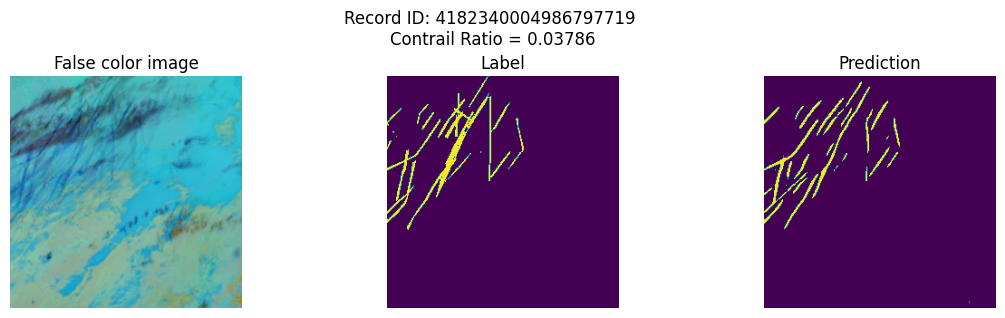

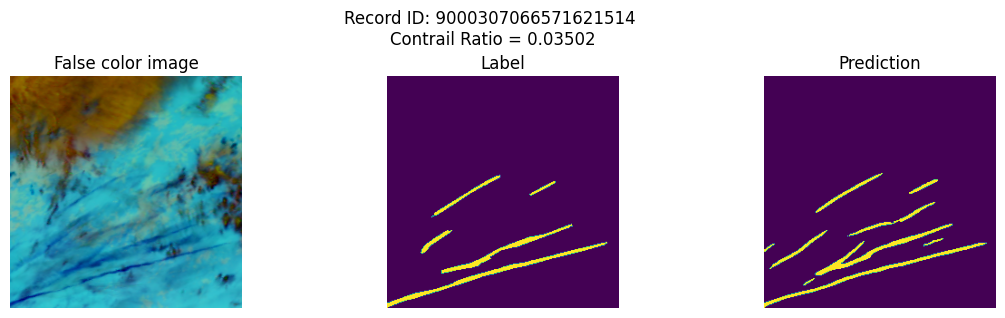

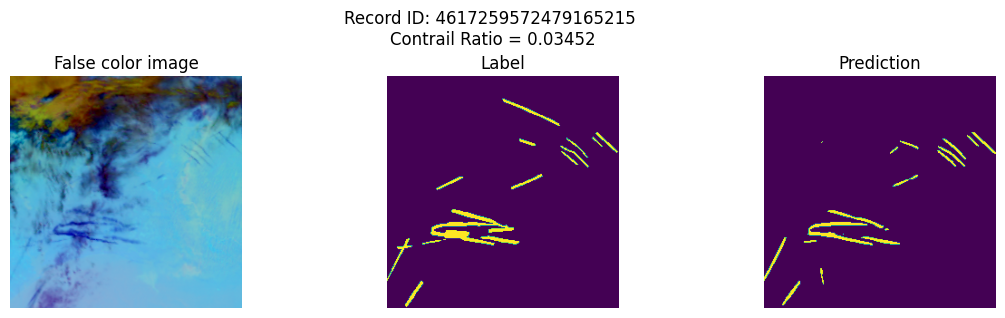

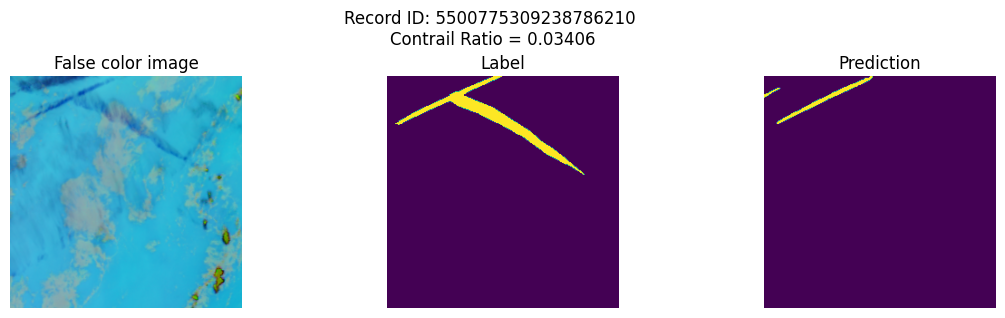

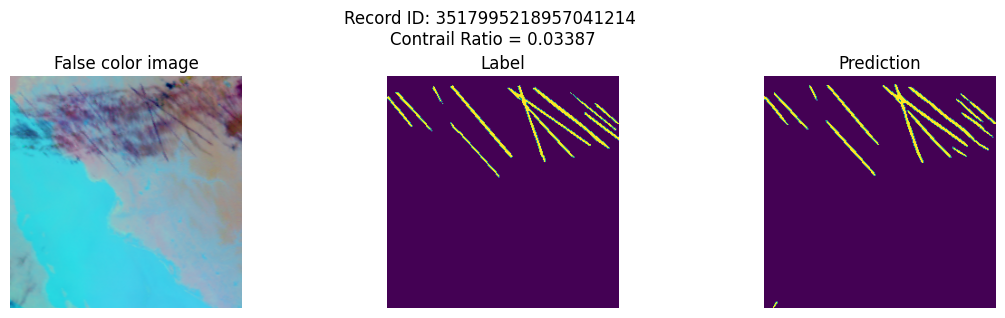

In [10]:
# Display the top N validation images with most contrails and compare with label
N = 10
# Get the top N validation records with more contrails (higher contrail ratio)
top_contrails_validation_records = validation_df.sort_values('contrail_ratio',ascending=False)[:N].values.tolist()

for record in top_contrails_validation_records:
    display_image_and_label(record[0], record[1], record[2], model)

In [11]:
# Single image visual inspection
nth_image = 8
label = np.load(top_contrails_validation_records[nth_image][0] + str(top_contrails_validation_records[nth_image][1]) + '/human_pixel_masks.npy')
ash_image = np.load(top_contrails_validation_records[nth_image][0] + str(top_contrails_validation_records[nth_image][1]) + '/ash_image.npy')[...,4]
y_pred = model.predict(ash_image.reshape(1,256, 256, 3))
prediction = np.argmax(y_pred[0], axis=2).reshape(256,256,1)
intersection = label & prediction
false_negative = label - intersection
false_possitive = prediction - intersection 
color_prediction = np.stack([false_negative*.7, intersection*.7, false_possitive*.7], axis=2).reshape(256,256,3)

1/1 [==============================] - 0s 25ms/step


(-0.5, 255.5, 255.5, -0.5)

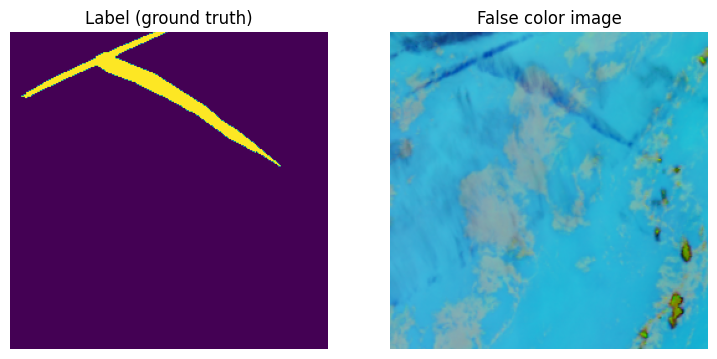

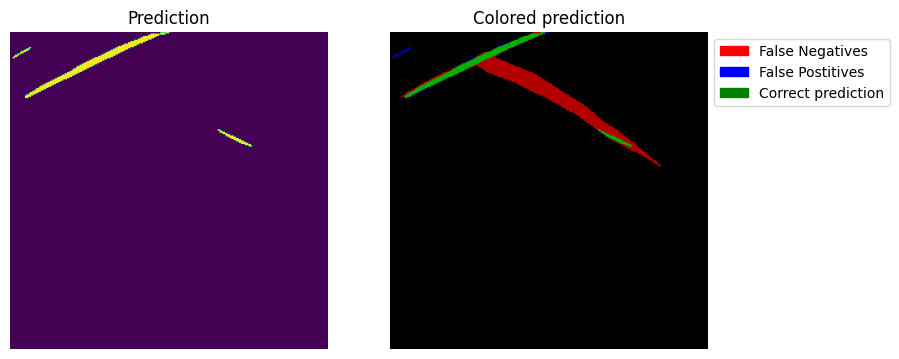

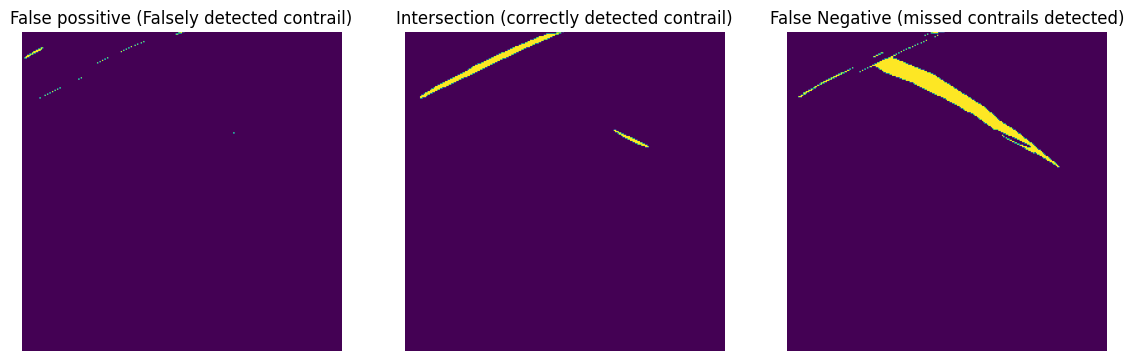

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(9, 6))
ax[0].set_title("Label (ground truth)")
ax[0].imshow(label)
ax[0].axis('off')

ax[1].set_title("False color image")
ax[1].imshow(ash_image)
ax[1].axis('off')


fig, ax = plt.subplots(1, 2, figsize=(9, 6))
# fig.tight_layout()

red_patch = mpatches.Patch(color='red', label='False Negatives')
blue_patch = mpatches.Patch(color='blue', label='False Postitives')
green_patch = mpatches.Patch(color='green', label='Correct prediction')



ax[0].imshow(prediction)
ax[0].set_title("Prediction")
ax[0].axis('off')

ax[1].imshow(color_prediction)
ax[1].set_title("Colored prediction")
ax[1].axis('off')
ax[1].legend(handles=[red_patch, blue_patch, green_patch],loc='upper left', bbox_to_anchor=(1, 1))



fig, ax = plt.subplots(1, 3, figsize=(14, 6))
# fig.tight_layout(pad=5.0)
ax[0].imshow(false_possitive)
ax[0].set_title("False possitive (Falsely detected contrail)")
ax[0].axis('off')

ax[1].imshow(intersection)
ax[1].set_title("Intersection (correctly detected contrail)")
ax[1].axis('off')

ax[2].imshow(false_negative)
ax[2].set_title("False Negative (missed contrails detected)")
ax[2].axis('off')

   